# Assignment 2

## *Does a job training program improve the earnings of disadvantaged workers?*

In [1]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")


# Core
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

# Data
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

<h2>Introduction</h2>

<p><strong>Business Context.</strong> In the 1980s, Robert Lalonde conducted a study to evaluate the effects of training programs on labour workers. He observed the characteristic background data of the individuals involved. Several of them were selected for enrollment in the job training program (the National Supported Work Demonstration). The training program specifically targeted unemployed women, ex-drug addicts, ex-criminal offenders, and high school dropouts.</p>
<p><img src="trainingfailsmain.jpg" width="550" alt="Labour Training"></p>
<p>The Department of Labor is interested in digging deeper into this data and coming up with some actionable insights in order to raise the earnings of disadvantaged workers. They have contracted you as a data science consultant to assist them with this task.</p>
<p><strong>Business Problem.</strong> Your goal is to evaluate <strong>whether the job training program <em>causes</em> the earnings of disadvantaged workers to go up</strong>.</p>
<p><strong>Analytical Context.</strong> In this case we will continue our discussion of causal inference. We will study the importance of covariate balance and explore how to perform matching to get this balance. We will leverage a lot of the new classification models we have learned for this purpose.</p>

<h2>Examining the data</h2>
<p>The Lalonde dataset provides information on annual income for workers who enroll in the training workshop and those who did not enroll in the year subsequent to training. The outcome of interest is <code>re78</code> in which we want to know if there was an increase in earnings in 1978:</p>
<ol>
<li><strong>age</strong>: age in years</li>
<li><strong>educ</strong>: years of schooling</li>
<li><strong>black</strong>: indicator variable for blacks</li>
<li><strong>hisp</strong>: indicator variable for Hispanics</li>
<li><strong>married</strong>: indicator variable for martial status</li>
<li><strong>nodegr</strong>: indicator variable for high school diploma</li>
<li><strong>re74</strong>: real earnings in 1974</li>
<li><strong>re75</strong>: real earnings in 1975</li>
<li><strong>re78</strong>: real earnings in 1978 - this is the outcome of interest</li>
<li><strong>treat</strong>: an indicator variable for treatment status</li>
</ol>

In [2]:
lalonde_df = pd.read_csv('lalonde.csv', index_col=0)
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


<h3>Exercise 1:</h3>
<h4>1.1</h4>
<p>Provide summary statistics for all the variables in the dataset. What can you say about the average income of the population throughout the years? What percentage of the population saw a decrease in income from 1974 to 1975? What do you think happened in 1975?</p>

**Answer.**

In [3]:
lalonde_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


It seems that there was a sharp decrease in the average income from 1974 to 1975, and then an even sharper increase from 1975 to 1978, so something drastic mustve happened in 1975.

In [4]:
pop_income_dec = lalonde_df[lalonde_df['re75']<lalonde_df['re74']].shape[0]
total_pop = lalonde_df.shape[0]
percent_decrease = (pop_income_dec/total_pop)*100
print(percent_decrease) #It shows that %46.42 of the population saw a decrease in income from '74 to '75.


46.416938110749186


The decrease could be due to any number of socioeconomic factors, though I suspect the most likely culprits to be a recession and/or general economic turmoil and/or high unemployment rates (either in general or particularily for low-skill labor).

<h4>1.2</h4>
<p>What percentage of the workers in our dataset are in the treatment group? Find the difference in means and medians of earnings between the control group and the treatment group. Is the difference of means statistically significant?</p>
<p><strong>Note:</strong> Remember that the <em>treatment and control groups</em> correspond to the sets of workers that were enrolled and not enrolled in the job training program, respectively. We can check if a worker is part of the treatment group by simply checking the value of the  <code>treat</code> column.</p>

**Answer.**

In [5]:
treatment_df = lalonde_df[lalonde_df['treat'] == 1] #Treatment percent
control_df = lalonde_df[lalonde_df['treat'] == 0]
treatment_percent = (treatment_df.shape[0]/lalonde_df.shape[0])*100
treatment_percent

30.130293159609124

In [6]:
from scipy import stats
control_stats_df = control_df.describe()
treatment_stats_df = treatment_df.describe()


control_avg = control_stats_df.loc['mean', 're74':'re78']
treat_avg = treatment_stats_df.loc['mean', 're74':'re78']

control_median = control_stats_df.loc['50%', 're74':'re78']
treat_median = treatment_stats_df.loc['50%', 're74':'re78']

mean_diff = abs(control_avg - treat_avg)
med_diff = abs(control_median - treat_median)

print(mean_diff)
print(med_diff)

stats.ttest_ind(control_avg, treat_avg) #p-value indicates no statistical significance


re74    3523.662818
re75     934.429129
re78     635.026212
Name: mean, dtype: float64
re74    2547.047
re75    1086.726
re78     743.196
Name: 50%, dtype: float64


TtestResult(statistic=0.8382832625650273, pvalue=0.4490422753056223, df=4.0)

<h4>1.3</h4>
<p>Does your previous result mean that the treatment had a negative impact? Why or why not?</p>

**Answer.**

No, because according to the calculated p-value, there is no statistical significance between the difference of means between groups. 

## Assessing balance between the control group and the treatment group

Suppose we want to assess whether balance has been achieved for a particular feature $x = age$. That is, we would like to check whether the treatment and control groups have similar distributions of ages. We can look at **Standardized Mean Differences (SMD)**, which is calculated as follows: let $(\bar{x}_t,s_t^2)$ and $(\bar{x}_c, s_c^2)$ denote the mean and variance corresponding to the treatment and control groups of the particular feature of interest. Then, the SMD is defined as the value:

$$\mathrm{SMD}(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}}.$$

We can calculate the SMD for every feature. If our calculated SMD is 1, then that means there is a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that is commonly used to determine whether that feature is balanced or not (similar to the idea of using 0.05 as a threshold for $p$ - values):

1. **SMD < 0.1**: We say that the feature is balanced. In general, for a **randomized trial**, the SMD for all of the covariates should typically fall into this bucket.
2. **SMD is between 0.1 and 0.2**:  Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose SMD falls in this range.
3. **SMD > 0.2**: Values that are greater than this threshold are considered seriously imbalanced.

<h3>Exercise 2:</h3>
<h4>2.1</h4>
<p>Assess covariate balance between the treatment and control groups. What features (covariates) are imbalanced between the control group and the treatment group in this dataset?</p>

**Answer.**

In [7]:
treatment_df_copy = treatment_df.drop(labels = ['treat'], axis = 1)
control_df_copy = control_df.drop(labels = ['treat'], axis = 1)
smd = {}
for col in treatment_df_copy.columns:
    treat_mean, ctrl_mean = treatment_df_copy[col].mean(), control_df_copy[col].mean()
    treat_std, ctrl_std = treatment_df_copy[col].std(), control_df_copy[col].std()
    denominator = np.sqrt((treat_std**2 + ctrl_std**2)/2)
    smd[col] = abs(treat_mean - ctrl_mean)/denominator
smd

{'age': 0.24190362292609968,
 'educ': 0.04475508511087086,
 'black': 1.6677188107185172,
 'hispan': 0.2769395965062943,
 'married': 0.7194919624729043,
 'nodegree': 0.23504820466514967,
 're74': 0.5957515910049505,
 're75': 0.2870021087425329,
 're78': 0.0837080938639525}

Every feature expect re78 and educ are heavily imbalanced between the treatment and control groups.

<h4>2.2</h4>
<p>Make plots which show the histograms for both the treatment and control groups of the imbalanced covariates.</p>

**Answer.**

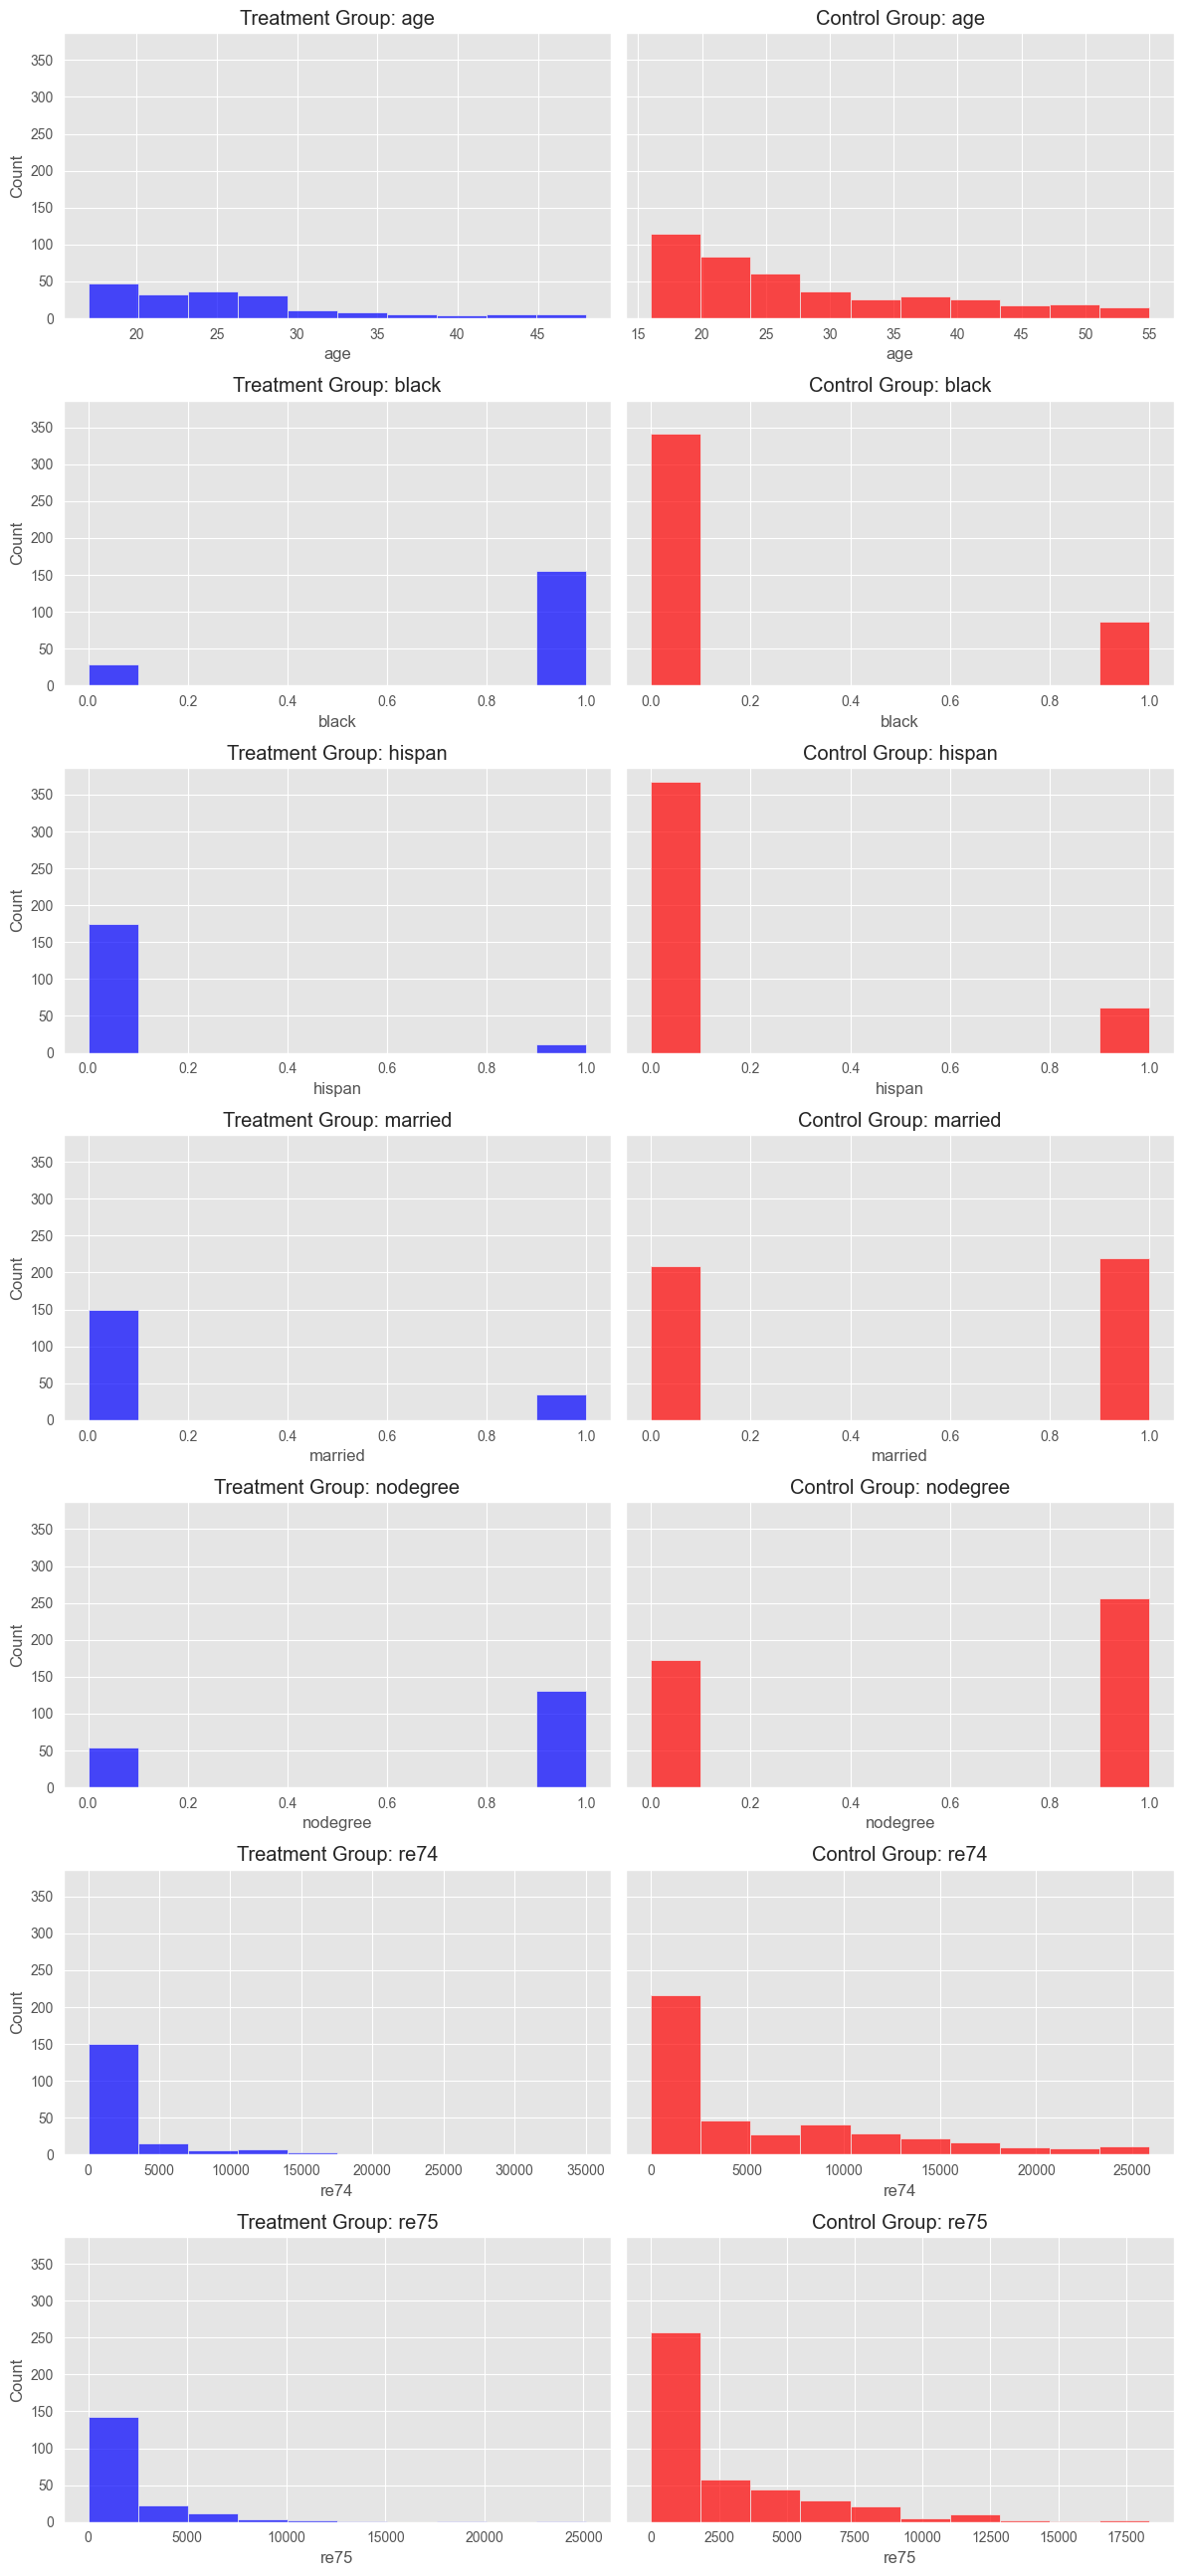

In [8]:

imbalanced_covariates = [cov for cov, smd in smd.items() if smd > 0.1]

num_covariates = len(imbalanced_covariates)
fig, axes = plt.subplots(num_covariates, 2, figsize=(12, 26), sharey=True)

for i, cov in enumerate(imbalanced_covariates):
    # Treatment hist
    sns.histplot(treatment_df_copy[cov], bins=10, kde=False, color='blue', alpha=0.7, ax=axes[i, 0])
    axes[i, 0].set_title(f"Treatment Group: {cov}")
    axes[i, 0].set_xlabel(cov)
    axes[i, 0].set_ylabel("Count")

    # Ctrl hist
    sns.histplot(control_df_copy[cov], bins=10, color='red', alpha=0.7, ax=axes[i, 1])
    axes[i, 1].set_title(f"Control Group: {cov}")
    axes[i, 1].set_xlabel(cov)
    
plt.tight_layout()
plt.show()

<h2>Propensity score matching using logistic regression</h2>

<p>In order to balance the covariates of the control and treatment groups, we will use <strong>matching</strong>. Remember that we used matching in Case 7.5 to balance a population of prisoners to evaluate the effectiveness of a program aiming to reduce recidivism. Thus, the situation here is quite similar.</p>
<p>In Case 7.5 we used the <em>Euclidean distance</em> on the sample data to create the matching: for each individual of the treatment group, we would find the closest (in Euclidean distance) individual in the control group to match on. Although this method is attractive in general, we may have instances in which the balancing of some particular feature is more important than others. Say the employment program was aiming to create a positive impact within the Hispanic community and a higher proportion of individuals in the treatment group were Hispanic. The Euclidean distance would not take this into account, and we may end up comparing the effect of the treatment between Hispanics and other ethnicities.</p>
<p>We can alleviate this issue by using a metric that takes into account the characteristics of the treatment group. In this context, a metric called the <strong>propensity score</strong> helps us do the matching on select features in an efficient way. The key idea is that <em>the features that are correlated with the probability of a worker being selected into the treatment group affect our causal results</em>. A propensity score is this probability. The propensity score for subject $i$, denoted as $\pi_i$ is defined as:</p>
<p>$\pi_i$ = P(Subject $i$ is given training given their features $X_i$)</p>
<p>As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they were placed in the treatment group. We can calculate this score by fitting a classification model to our data, where the input features are our covariates, and the output is whether that person was part of the treatment group or not.</p>

<h3>Exercise 3:</h3>
<h4>3.1</h4>
<p>Estimate the propensity scores using a logistic regression. Build a logistic regression model where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except <code>re78</code>. How would you interpret the predicted values output by the model? </p>

**Answer.**

In [22]:
# logist_df = lalonde_df.copy()
# outcome_var = logist_df['treat']
# covars = logist_df.drop(columns = ['re78'])
# from sklearn.linear_model import LogisticRegression            # For sklearn model
# model = LogisticRegression(penalty='l2')  # Regularization
# model.fit(covars, outcome_var)



covars = sm.add_constant(covars)

logit_reg = sm.Logit(outcome_var, covars)
result = logit_reg.fit() 

print(result.summary())

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      604
Method:                           MLE   Df Model:                            9
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                   1.000
Time:                        02:22:42   Log-Likelihood:            -7.1885e-05
converged:                      False   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                5.836e-156
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24.0182   4467.445     -0.005      0.996   -8780.049    8732.013
treat         51.6369   5031.108      0.010      0.992   -9809.15

C:\Users\fadav\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\fadav\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\fadav\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<h4>3.2</h4>
<p>Use <code>.predict()</code>  to obtain the propensity scores of individuals in our dataset. Save the the results with the name <code>pscore_logit</code> (these will be used later). In addition, make plots which show the distribution for both the treatment and control groups of propensity scores.</p>

**Answer.**

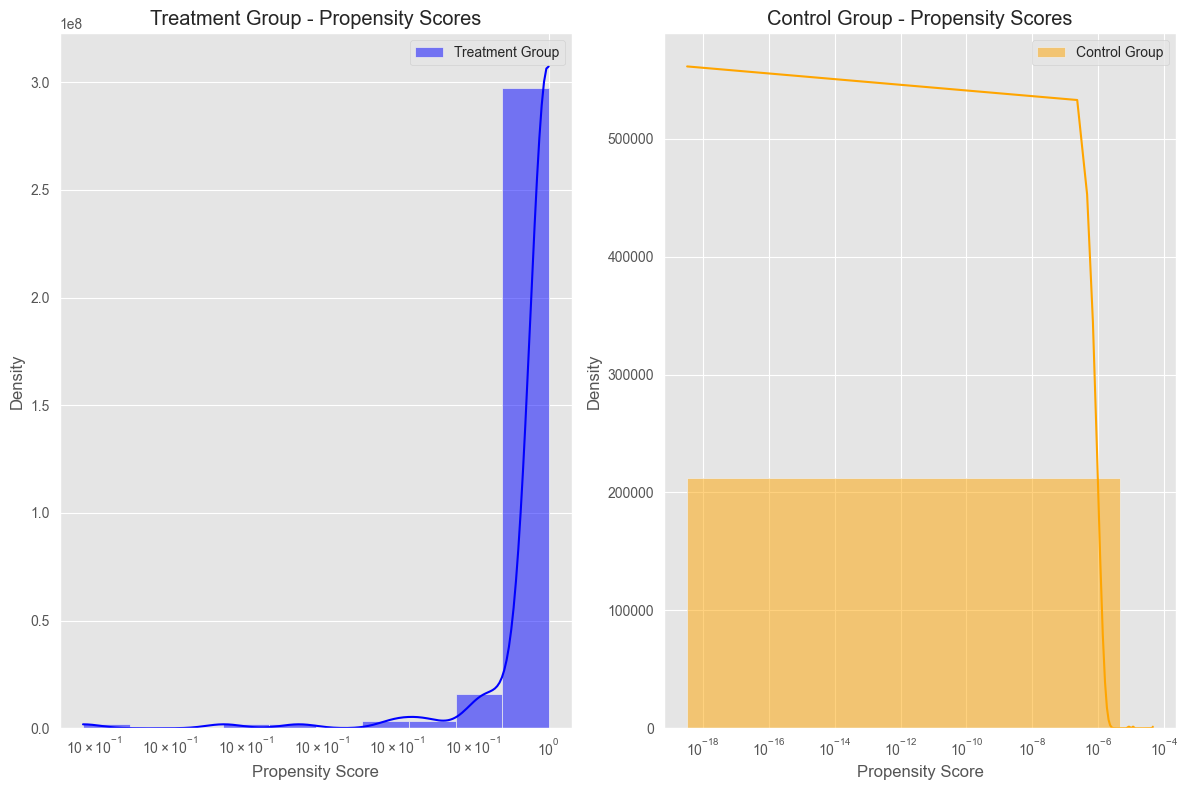

In [25]:
# pscore_logit = model.predict(covars) #for sklearn model

pscore_logit = result.predict(covars)
logist_df['pscore_logit'] = pscore_logit

treat_propen = logist_df.loc[logist_df['treat'] == 1, 'pscore_logit']
control_propen = logist_df.loc[logist_df['treat'] == 0, 'pscore_logit']

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.histplot(treat_propen, kde=True, color="blue", label="Treatment Group", stat="density", bins=10)
plt.title("Treatment Group - Propensity Scores")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.xscale('log')  # Apply log scale to x-axis
plt.legend()

# Histogram for Control Group
plt.subplot(1, 2, 2)
sns.histplot(control_propen, kde=True, color="orange", label="Control Group", stat="density", bins=10)
plt.title("Control Group - Propensity Scores")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.xscale('log')  # Apply log scale to x-axis
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()




### Matching using $k$-nearest neighbors

We are going to match each treated subject with a control subject using nearest neighbors matching on the estimated propensity score. Here, we use another popular clustering algorithm: the **$k$-nearest neighbors ($k$-NN) algorithm**. This algorithm is quite similar to the one we used in Case 7.5. However, instead of finding the single control individual with the closest propensity score, it finds the $k$ control individuals with the closest propensity scores. The use of $k>1$ is handy for classification purposes: if each individual lies in a category, we can classify a new individual by finding its $k$ nearest neighbors and use the most common category of its neighbors as the selected category for the new individual. 

<h3>Exercise 4 :</h3>
<p>In this exercise, we will use the <code>sklearn.neighbors</code> function <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors"><code>NearestNeighbors</code></a> to find, for each subject in the treatment group, the $k=5$ subjects in the control group with the closest propensity scores.</p>
<h4>4.1</h4>
<p>Separate the propensity scores <code>pscore_logit</code> found in Exercise 3 for treatment and control groups. Call these <code>treat_pscores</code> and <code>control_pscores</code> respectively. Use the <code>control_pscores</code> to train a $k$-NN algorithm with $k=5$.</p>
<p><strong>Hint:</strong> Load the model using <code>knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')</code>. You may want to reshape the control scores using <code>control_pscores.reshape(-1,1)</code>.</p>

**Answer.**

-------

<h4>4.2</h4>
<p>Find the indices of the five nearest neighbors using the method <code>.kneighbors()</code> applied to <code>treat_pscores</code>. </p>

**Answer.**

-------

<h4>4.3</h4>
<p>Match the treatment and control groups using the closest of the five neighbors found above. Your output should be a pair of <code>DataFrames</code>, each with $185$ rows from the <code>lalonde_df</code>. The first should correspond to the treatment group and the second should correspond to the matched control group.</p>

**Answer.**

-------

<h3>Propensity score distribution plot after matching</h3>
<p>Let's take a glance at the distribution of propensity score after matching. Both groups have similar distributions on the propensity score. This means we have reach a balance in both groups. This enables us to further analyze the causality effect of the treatment.</p>

<h3>Exercise 5 :</h3>
<p>Make a plot which shows the histograms of propensity scores for the control and treatment groups after matching. Compare your results with the plot in Exercise 3.2.</p>

**Answer.**

-------

<h3>Exercise 6 :</h3>

Assess covariate balance after the $k$-NN matching.  For this, compute the absolute standardized differences in means in the covariates after matching,  $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$ where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are, respectively, the means of covariate $x$ in the treatment and control groups after matching, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are, correspondingly, the sample variances treatment and control groups before matching. 

One reason to use the sample variances before matching rather than the sample variances after matching is to free the comparisons of the means after matching from simultaneous changes in the variances. Comment on covariate balance.

**Answer.**

-------

<h3>Exercise 7 :</h3>
<p>Estimate the average effect of treatment on <font color='red'> wages (<code>re78</code>) </font> after matching. What do you conclude?</p>

**Answer.**

-------

<h2>Propensity score matching using decision trees and random forests</h2>

<h3>Exercise 8 :</h3>
<p>To validate our propensity score calculations, let's try calculating them using other models such as decision trees and random forests.</p>

<h4>8.1</h4>
<p>Build a decision tree regressor where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except <code>re78</code>. Use the <code>sklearn.tree</code> function <code>DecisionTreeRegressor(max_depth=4)</code> and call the new propensity scores <code>pscore_tree</code>.</p>

**Answer.**

-------

<h4>8.2</h4>
<p>Plot the decision tree regressor using the code</p>
<div class="codehilite"><pre><span></span><code><span class="err">fig = plt.gcf()</span>
<span class="err">fig.set_size_inches(150, 100)</span>
<span class="err">tree.plot_tree(dt,filled=True,feature_names=cleaned_df.columns)</span>
<span class="err">fig.savefig(&#39;tree.png&#39;)</span>
</code></pre></div>


<p>Replace <code>dt</code> with the name of the model created in Exercise 8.1. Use the plot to estimate the probability that a 24 year old, single, uneducated Hispanic individual that earned $\$20000$ in 1974 was enrolled in the employment program. Do the same with a black man with the same characteristics. (Assume that there were no black Hispanics in the study.)</p>

**Answer.**

-------

<h4>8.3</h4>
<p>Estimate the propensity scores now by using random forests. For the model, use the <code>sklearn.ensemble</code> function <code>RandomForestClassifier</code> with parameters <code>n_estimators=100, max_depth=4, random_state=42</code>. Then, use the method <code>predict_proba</code> to extract the propensity scores. Name the scores <code>pscore_forest</code>.</p>

**Answer.**

-------

<h4>8.4</h4>
<p>Make a plot with the three ROC curves corresponding to the logistic regression, decision tree, and random forest classifiers used to compute the propensity scores. What is the AUC of each model? Which model <em>seems</em> to do the best job?</p>

**Answer.**

-------

<h4>8.5</h4>
<p>Consider the following statement:</p>
<blockquote>
<p>"<em>A model with a higher AUC provides much better estimates of the true propensity scores. In particular, a matching using the propensity scores of such a model will balance the covariates much better.</em>"</p>
</blockquote>
<p>Is the statement true or false? Explain. </p>

**Answer.**

-------

<h4>8.6</h4>
<p>Repeat the matching procedure now with the estimated propensity scores <code>pscore_tree</code> and <code>pscore_forest</code>. Assess the covariate balances and estimate the average effect of treatment on wages (<code>re78</code>) after matching. Compare your results. </p>

**Answer.**

-------

<h4>8.7</h4>
<p>Why do you think the decision tree regressor performed badly on balancing the covariates of the treat and control groups?  </p>
<p><strong>Hint:</strong> Look at the distances of the ten nearest neighbors output by <code>.kneighbors()</code> for the propensity scores of the decision tree model. What do you see? Why do you think these distances may have an impact on balancing?</p>

**Answer.**

-------